In [4]:
# Common imports
import numpy as np
import os
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [5]:
rDet         = np.array([0.5, 1.0, 1.5, 2, 2.5,3.0])
nModPerLayer = np.array([14,   28,  42, 56, 70, 84])

xDet = np.linspace(-3, 3, 5000)
yDet = np.sqrt(0.5**2-xDet**2)

/home/zihaoj/CS234/.env/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


# Helper Functions

In [6]:
# Note there are 2 different phis used:
#   - phi_circle (the angle of the center of the circle in r-phi plane)
#   - phi_track (the direction of the particle that made the track) 
#
#  For positive tracks: phi_circle = phi_track - pi/2
#  For negative tracks: phi_circle = phi_track + pi/2
from TrackingToy.TrackHelper import getPhiCircle
from TrackingToy.TrackHelper import drawTrack

# Now Detector Classes


In [7]:
from TrackingToy.detectorGeo import detectorGeo

1.34639685154


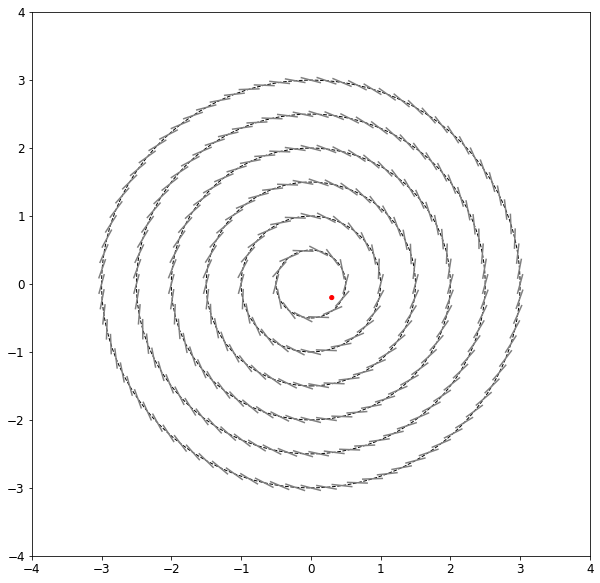

In [8]:
fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 4
ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

detGeo = detectorGeo()
detGeo.initSimple(rDet,nModPerLayer)
detGeo.setBeamSpot(X = 0.3, Y =-0.2)

detGeo.drawDetector(ax,detailed=True)

print detGeo.layers[0].mods[3].phiCenter

# Make some Towers

OK move to a phi slice and start with FTK. Lets draw the SSIDs

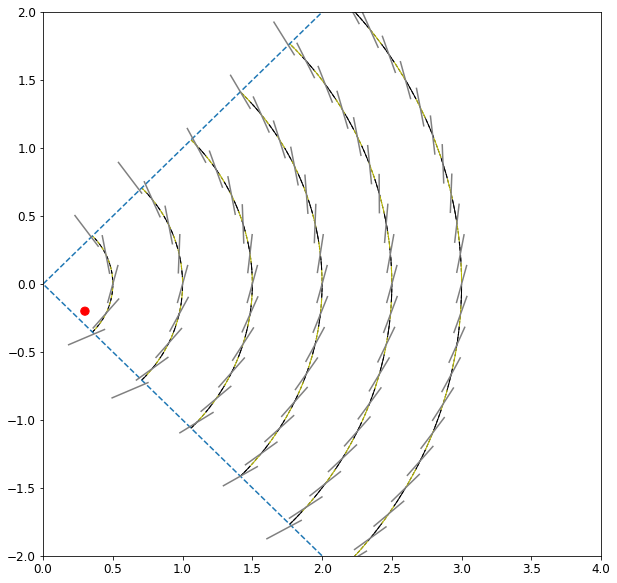

In [9]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((0, 4))
ax.set_ylim((-2, 2))
nSSperLayer=[30,30,30,30,30,30]


detGeo.makeTower(phiCenter=0*np.pi/12,  phiWidth=np.pi/2, nSS=nSSperLayer)
detGeo.drawTower(ax,detailed=True)


# Get sometracks for pattern matching

In [10]:
np.random.seed(42)

solutions_test  = []

phiRange = (-3*np.pi/12, 3*np.pi/12)

for trkI in range(10):
    
    ptInv = np.random.uniform(0.01,0.5,1)[0]
    phi   = np.random.uniform(phiRange[0],phiRange[1],1)[0]
    q     = 2*np.random.randint(0,2,1)[0]-1
    pt = 1./ptInv
    

    xHits, yHits, modulesHit, actualHits = detGeo.getHits(pt,phi,q)

    solutions_test.append([xHits,yHits,pt,phi,q,modulesHit,actualHits])


TrackingToy/layer.py:83: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pp = abs(yints_raw-(trk_yc+beamY)+np.sqrt(trk_rc2-(xints_p_raw-(trk_xc+beamX))**2))
TrackingToy/layer.py:84: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pm = abs(yints_raw-(trk_yc+beamY)-np.sqrt(trk_rc2-(xints_p_raw-(trk_xc+beamX))**2))
TrackingToy/layer.py:85: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mp = abs(yints_raw-(trk_yc+beamY)+np.sqrt(trk_rc2-(xints_m_raw-(trk_xc+beamX))**2))
TrackingToy/layer.py:86: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mm = abs(yints_raw-(trk_yc+beamY)-np.sqrt(trk_rc2-(xints_m_raw-(trk_xc+beamX))**2))


# Lets plot the SSIDs that are Hit as a sanity check

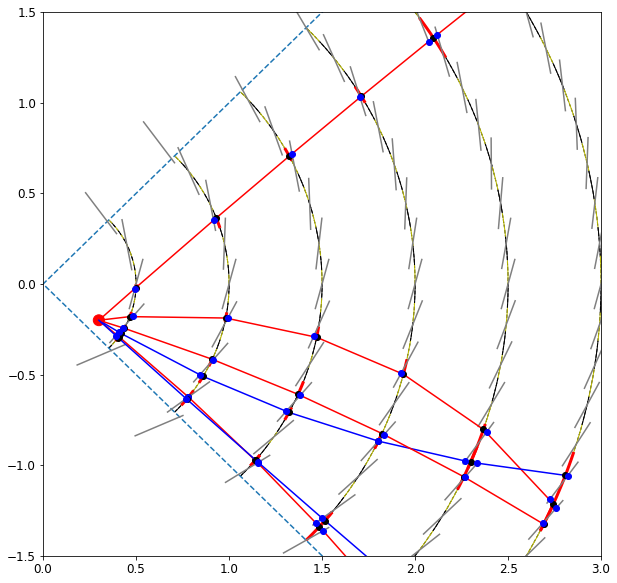

In [11]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((0, 3))
ax.set_ylim((-1.5, 1.5))

detGeo.drawTower(ax,detailed=True)
for sItr in range(10):
    s = solutions_test[sItr]

    if not detGeo.hitsAllInTower(s[6]): continue
    
    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],color)
    plt.plot( [detGeo.beamX, s[0][0]], [detGeo.beamY, s[1][0]], color   )    
        
    hitList = []
    realHits = s[6]
    for rHit in realHits:
        # hitITr / Layer / phiID / hit-X / hit-Y
        hitList.append(  [1,rHit[0],rHit[1],rHit[2], rHit[3]] )
        
        
    #print(s[6])
    hitsWithSSIDs = detGeo.addSSIDs(hitList)

    thisSSIDs = np.array(hitsWithSSIDs)
    thisSSIDs = np.delete(hitsWithSSIDs,0,axis=1) # rm hitID
    thisSSIDs = np.delete(thisSSIDs,1,axis=1)     # rm phiID
    thisSSIDs = np.delete(thisSSIDs,1,axis=1)     # rm hit X
    thisSSIDs = np.delete(thisSSIDs,1,axis=1)     # rm hit Y


    plt.plot(s[0],s[1],'ko')

    detGeo.drawSSIDs(ax,thisSSIDs)
    
    for ih, rH in enumerate(realHits):
        plt.plot(rH[2],rH[3],'bo')




OK now we are cooking with GAS

# OK Lets make some patterns 

In [12]:
from TrackingToy.TrackHelper import patternID

In [13]:
import os
import pickle

if os.path.isfile("patternsSimpleGeo_75k.pickle"):
    print("Loading Patterns")
    with open('patternsSimpleGeo_75k.pickle', 'rb') as handle:
        patternsBankLoaded = pickle.load(handle)
    
    patternBank         = patternsBankLoaded["bank"]
    passedTracksSamples = patternsBankLoaded["passedTracks"]
    patternBankSize     = patternsBankLoaded["bankSize"]

else:
    
    print("Making Patterns")
    
    np.random.seed(42)
    
    nTrk_pattGen = int(7.5e4)#int(7.5e2)
    solutions_pattGen  = []

    phiRange = (-3*np.pi/12, 3*np.pi/12)


    for trkI in range(nTrk_pattGen):
        
        ptInv = np.random.uniform(0.01,0.5,1)[0]
        phi   = np.random.uniform(phiRange[0],phiRange[1],1)[0]
        q     = 2*np.random.randint(0,2,1)[0]-1
        pt = 1./ptInv
        
        xHits, yHits, modulesHit, actualHits = detGeo.getHits(pt,phi,q)
        
        solutions_pattGen.append([xHits,yHits,pt,phi,q,modulesHit,actualHits])

    # The pattern bank
    patternBank = {}
    
    # For plotting
    passedTracks = 0
    passedTracksSamples = np.array([],float)
    patternBankSize = np.array([],float)
    
    for sItr in range(nTrk_pattGen):
        s = solutions_pattGen[sItr]

        if not detGeo.hitsAllInTower(s[6]): continue

        hitList = []
        realHits = s[6]
        for rHit in realHits:
            # hitITr / Layer / phiID / hit-X / hit-Y
            hitList.append(  [1,rHit[0],rHit[1],rHit[2], rHit[3]] )
    
            
        passedTracks += 1
        
        hitsWithSSIDs = detGeo.addSSIDs(hitList)
        
        # Get SSIds perlayer
        thisSSIDs = [] 
        for _ in range(len(rDet)): thisSSIDs.append([])
            
        for hinfo in hitsWithSSIDs:
            layer = int(hinfo[1])
            thisSSIDs[layer].append(hinfo[5])
        
        #
        #  Need one SSIDS per layer
        #        
        goodTrack = True
        for layItr, layerSSIDs in enumerate(thisSSIDs):
            if len(layerSSIDs) == 0:  
                #print("Using PS hit instead")
                #thisSSIDs[layItr].append()
                goodTrack = False
                #fig, ax = plt.subplots(1, figsize=(10,10))
                #ax.set_xlim((0, 3))
                #ax.set_ylim((-1.5, 1.5))
                
                #detGeo.drawTower(ax,detailed=True)
                #color = "b" if (s[4] < 0) else "r"
                #plt.plot(s[0],s[1],color)
                
            elif len(layerSSIDs) == 1:  
                pass # all good
            else:
                while(not len(thisSSIDs[layItr]) == 1):
                    thisSSIDs[layItr].pop(-1)
        if not goodTrack: continue
        thisPatternID = patternID(thisSSIDs,nSSperLayer)
        
        if thisPatternID not in patternBank:
            patternBank[thisPatternID] = 0
        
        patternBank[thisPatternID] += 1
        
        # Statistics
        if passedTracks %10 == 0:
            passedTracksSamples = np.append(passedTracksSamples,passedTracks)
            patternBankSize     = np.append(patternBankSize, len(patternBank))
    
    
    patternsBankToLoad = {}
    patternsBankToLoad["bank"]         = patternBank
    patternsBankToLoad["passedTracks"] = passedTracksSamples
    patternsBankToLoad["bankSize"]     = patternBankSize

    with open('patternsSimpleGeo_75k.pickle', 'wb') as handle:
        pickle.dump(patternsBankToLoad, handle, protocol=pickle.HIGHEST_PROTOCOL)

len(patternBank)

Loading Patterns


2407

Text(0,0.5,u'nPatterns')

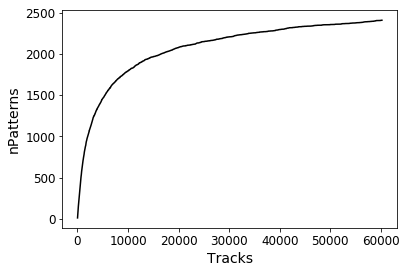

In [14]:
plt.plot(passedTracksSamples,patternBankSize,"k")
plt.xlabel("Tracks")
plt.ylabel("nPatterns")

# OK Lets try to do pattern matching with the pattern bank

Make an event with tracks

In [15]:
def getEvent(nTrks, phiCenter, phiWidth, det_geo, randSeed = 42, debug=False):
    np.random.seed(randSeed)

    # Kaggle formats
    eventParticles = []
    eventTruth = []
    eventHits = []

    # For plotting 
    solutions = []
    
    hitID = 0
    trkID = 0
    phiRange = (phiCenter-phiWidth/2, phiCenter+phiWidth/2)

    if debug: print("phiRange is",phiRange)
    nTrkPerPhiRegion = int(10) # with 50 tracks total ~10 in a phi slice
    for trkI in range(nTrks):
        ptInv = np.random.uniform(0.01,0.5,1)[0]
        phi   = np.random.uniform(phiRange[0],phiRange[1],1)[0]
        q     = 2*np.random.randint(0,2,1)[0]-1
        pt = 1./ptInv

        xHits, yHits, modulesHit, actualHits = det_geo.getHits(pt,phi,q)

        if not det_geo.hitsAllInTower(actualHits): 
            if debug: print("Skipping",phi)
            continue
        

        trkID += 1
        eventParticles.append((trkI,pt,phi,q,6))
        solutions.append([xHits,yHits,pt,phi,q,modulesHit,actualHits])
        for thisHit in actualHits:
            # hit_id, particle_id, tx, ty, tz, weight (=1 for now)
            eventTruth.append([hitID,trkID,thisHit[2],thisHit[3],1.0])
            eventHits .append([hitID,thisHit[0],thisHit[1],thisHit[2],thisHit[3]])        
            hitID += 1


    recHits = np.array(eventHits)
    shuffle_index = np.random.permutation(len(recHits))
    recHits = recHits[shuffle_index]

    return recHits, eventTruth, eventParticles, solutions

In [16]:
recHits, eventTruth, eventPartilces, solutions = getEvent(10, 0, np.pi/4, detGeo)

recHits[0:10] 

array([[53.        ,  4.        , 63.        ,  2.04479007, -1.45144739],
       [ 0.        ,  0.        ,  0.        ,  0.46344503, -0.136425  ],
       [26.        ,  5.        , 82.        ,  3.02480374, -0.31347597],
       [22.        ,  1.        , 27.        ,  0.91242669, -0.34077902],
       [12.        ,  5.        , 78.        ,  2.64361683, -1.37054719],
       [37.        ,  2.        , 40.        ,  1.43260536, -0.44333251],
       [10.        ,  4.        , 66.        ,  2.29705408, -0.93930756],
       [18.        ,  5.        , 77.        ,  2.69948783, -1.39858838],
       [ 4.        ,  4.        ,  5.        ,  2.25235392,  1.08507007],
       [32.        ,  4.        ,  3.        ,  2.4106771 ,  0.56216014]])

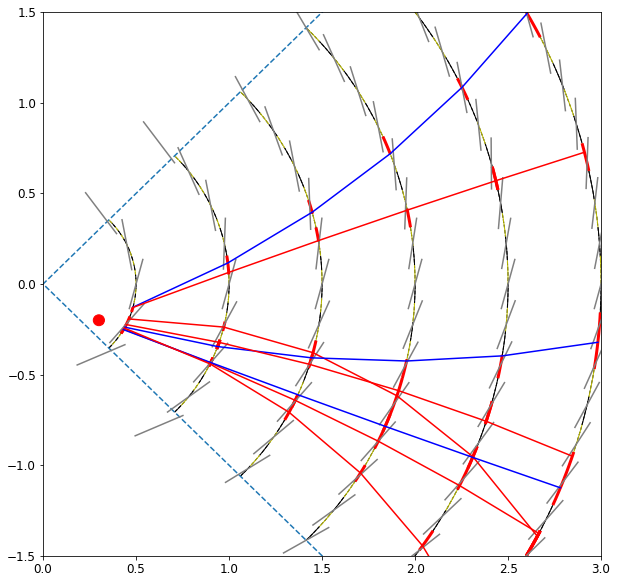

In [17]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((0, 3))
ax.set_ylim((-1.5, 1.5))

detGeo.drawTower(ax,detailed=True)
for sItr in range(len(solutions)):
    s = solutions[sItr]

    hitListTrk = []

    realHits = s[6]
    for rHit in realHits:
        # hitITr / Layer / phiID / hit-X / hit-Y
        hitListTrk.append(  [1,rHit[0],rHit[1],rHit[2], rHit[3]] )
        
    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],color)
    
    hitsWithSSIDs = detGeo.addSSIDs(hitListTrk)

    thisSSIDs = np.array(hitsWithSSIDs)
    thisSSIDs = np.delete(hitsWithSSIDs,0,axis=1) # rm hitID
    thisSSIDs = np.delete(thisSSIDs,1,axis=1)     # rm phiID
    thisSSIDs = np.delete(thisSSIDs,1,axis=1)     # rm hit X
    thisSSIDs = np.delete(thisSSIDs,1,axis=1)     # rm hit Y     

    detGeo.drawSSIDs(ax,thisSSIDs)


OK now loop over hits get SSIDS and match patterns

In [18]:
#print(recHits[0])
hitsAndSSIDS = detGeo.addSSIDs(recHits,debug=False)
#print(hitsAndSSIDS[0])
detGeo.DOWrite(hitsAndSSIDS)

In [19]:
patterns = patternBank.keys()
matchedPatterns = []
for p in patterns:

    if detGeo.isPatternFired(p): 
        matchedPatterns.append(p)

print(matchedPatterns)

[80707060604.0, 70910101007.0, 80909101007.0, 80910101007.0, 191918181609.0, 50608091007.0, 50708091007.0, 121110090805.0, 50606060604.0, 10304050605.0, 50608101007.0, 50708101007.0, 70708090806.0, 131110090805.0, 50606060605.0, 50709101007.0, 121110100805.0, 121110100806.0, 70606060604.0, 242322201709.0, 10304060605.0, 70706060604.0, 70707060604.0, 70707060605.0, 80909090805.0, 80909090806.0]


In [21]:
from TrackingToy.TrackHelper import getSSIDS

80707060604.0
[(0, 4), (1, 6), (2, 6), (3, 7), (4, 7), (5, 8)]
70910101007.0
[(0, 7), (1, 10), (2, 10), (3, 10), (4, 9), (5, 7)]
80909101007.0
[(0, 7), (1, 10), (2, 10), (3, 9), (4, 9), (5, 8)]
80910101007.0
[(0, 7), (1, 10), (2, 10), (3, 10), (4, 9), (5, 8)]
1.91918181609e+11
[(0, 9), (1, 16), (2, 18), (3, 18), (4, 19), (5, 19)]
50608091007.0
[(0, 7), (1, 10), (2, 9), (3, 8), (4, 6), (5, 5)]
50708091007.0
[(0, 7), (1, 10), (2, 9), (3, 8), (4, 7), (5, 5)]
1.21110090805e+11
[(0, 5), (1, 8), (2, 9), (3, 10), (4, 11), (5, 12)]
50606060604.0
[(0, 4), (1, 6), (2, 6), (3, 6), (4, 6), (5, 5)]
10304050605.0
[(0, 5), (1, 6), (2, 5), (3, 4), (4, 3), (5, 1)]
50608101007.0
[(0, 7), (1, 10), (2, 10), (3, 8), (4, 6), (5, 5)]
50708101007.0
[(0, 7), (1, 10), (2, 10), (3, 8), (4, 7), (5, 5)]
70708090806.0
[(0, 6), (1, 8), (2, 9), (3, 8), (4, 7), (5, 7)]
1.31110090805e+11
[(0, 5), (1, 8), (2, 9), (3, 10), (4, 11), (5, 13)]
50606060605.0
[(0, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 5)]
50709101007.0
[(0,

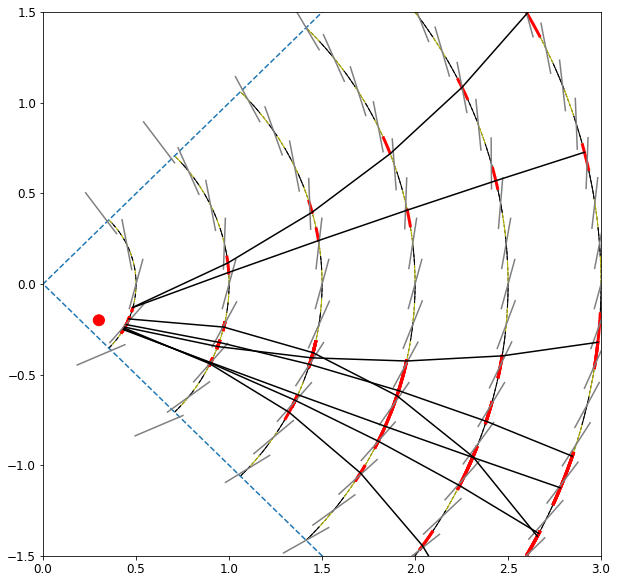

In [22]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((0, 3))
ax.set_ylim((-1.5, 1.5))


detGeo.drawTower(ax,detailed=True)
for mp in matchedPatterns:
    print(mp)            
    thisSSIDs = getSSIDS(mp)
    print(thisSSIDs)
    detGeo.drawSSIDs(ax,thisSSIDs)
    
for sItr in range(len(solutions)):
    s = solutions[sItr]

    color = "k"
    plt.plot(s[0],s[1],color)

In [23]:
solns, _  = detGeo.getSolutions(matchedPatterns)
solns.head()
solns

,event_id,hit_id,track_id
0,0,42.0,1
1,0,13.0,1
2,0,14.0,1
3,0,43.0,1
4,0,50.0,1
5,0,15.0,1
6,0,44.0,1
7,0,45.0,1
8,0,46.0,1
9,0,10.0,1


In [25]:
from TrackingToy.TrackHelper import getTruthDF


In [26]:
truth = getTruthDF(eventTruth)
truth.head()

,hit_id,particle_id,weight
0,0.0,1.0,1.0
1,1.0,1.0,1.0
2,2.0,1.0,1.0
3,3.0,1.0,1.0
4,4.0,1.0,1.0


In [29]:
import TrackingToy.score
score.score_event(truth,solns)

ImportError: No module named score

Giddy up

# OK see if we can get the a differnet region of phi working with the same pattern bank

In [ ]:
detGeo_up = detectorGeo()
detGeo_up.initSimple(rDet,nModPerLayer)
detGeo_up.makeTower(np.pi/2,  np.pi/2, nSS=nSSperLayer)

fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((0, 3))

detGeo_up.drawTower(ax,detailed=True)

In [ ]:
#np.random.seed(24)
recHits_up, eventTruth_up, eventPartilces_up, solutions_up = getEvent(10, np.pi/2, np.pi/4, detGeo_up)
recHits_up[0:10]

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((0, 3))

detGeo_up.drawTower(ax,detailed=True)
for sItr in range(len(solutions_up)):
    s = solutions_up[sItr]

    hitListTrk = []

    realHits = s[6]
    for rHit in realHits:
        # hitITr / Layer / phiID / hit-X / hit-Y
        hitListTrk.append(  [1,rHit[0],rHit[1],rHit[2], rHit[3]] )
        
    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],color)
    
    hitsWithSSIDs = detGeo_up.addSSIDs(hitListTrk)

    thisSSIDs = np.array(hitsWithSSIDs)
    thisSSIDs = np.delete(hitsWithSSIDs,0,axis=1) # rm hitID
    thisSSIDs = np.delete(thisSSIDs,1,axis=1)     # rm phiID
    thisSSIDs = np.delete(thisSSIDs,1,axis=1)     # rm hit X
    thisSSIDs = np.delete(thisSSIDs,1,axis=1)     # rm hit Y     

    detGeo_up.drawSSIDs(ax,thisSSIDs)

In [ ]:
#print(recHits_up)
#print(eventHits_up)
hitsAndSSIDS_up = detGeo_up.addSSIDs(recHits_up)
detGeo_up.DOWrite(hitsAndSSIDS_up)

In [ ]:
patterns = patternBank.keys()
matchedPatterns_up = []
for p in patterns:

    if detGeo_up.isPatternFired(p): 
        matchedPatterns_up.append(p)

print(matchedPatterns_up)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_ylim((0, 3))
ax.set_xlim((-1.5, 1.5))


detGeo_up.drawTower(ax,detailed=True)
for mp in matchedPatterns_up:
    thisSSIDs = getSSIDS(mp)
    detGeo_up.drawSSIDs(ax,thisSSIDs)
    
for sItr in range(len(solutions_up)):
    s = solutions_up[sItr]

    color = "k"
    plt.plot(s[0],s[1],color)

In [ ]:
solns_up, _  = detGeo_up.getSolutions(matchedPatterns_up)
truth_up = getTruthDF(eventTruth_up)


In [ ]:
score.score_event(truth_up,solns_up)

# OK pretty clear differnet regions are working, lets to the whole event

Get full event

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((-3.5, 3.5))
ax.set_ylim((-3.5, 3.5))

detGeo_All = detectorGeo()
detGeo_All.initSimple(rDet,nModPerLayer)
detGeo_All.makeTower(0,  2*np.pi, nSS=nSSperLayer)

detGeo_All.drawDetector(ax)

recHits_All, eventTruth_All, eventPartilces_All, solutions_All = getEvent(50, 0, 2*np.pi, detGeo_All,randSeed=2)


for sItr in range(len(solutions_All)):
    s = solutions_All[sItr]
    


    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],color)
    

In [ ]:

fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((-3.5, 3.5))
ax.set_ylim((-3.5, 3.5))
nTowers = 7
towerWidth = np.pi/2

towers = []
for iT in range(nTowers):
    towers.append(detectorGeo())
    towers[-1].initSimple(rDet,nModPerLayer)
    towers[-1].makeTower(2*iT*np.pi/nTowers, towerWidth, nSS=nSSperLayer)

    towers[-1].drawTower(ax,detailed=True)

for sItr in range(50):
    s = solutions_All[sItr]

    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],"ro")

In [ ]:
import pandas as pd

evt_id_all = []
hit_id_all = []
trk_id_all = []

patterns = patternBank.keys()

for t in towers:
    hitsAndSSIDS_All = t.addSSIDs(recHits_All,filterOnTower=True)
    t.DOWrite(hitsAndSSIDS_All)


    thisMatchedPatterns = []
    for p in patterns:

        if t.isPatternFired(p): 
            thisMatchedPatterns.append(p)
    
    if len(trk_id_all): trkID = trk_id_all[-1]+1
    else:               trkID = 0
    
    thisSolns, thisSolnsDetails = t.getSolutions(thisMatchedPatterns,trkIDInit=trkID)
    
    # need over lap removal!
    
    evt_id_all += thisSolnsDetails[0]
    hit_id_all += thisSolnsDetails[1]
    trk_id_all += thisSolnsDetails[2]    

solnDictAll = {"event_id" : pd.Series(evt_id_all),
               "hit_id" : pd.Series(hit_id_all),
               "track_id" : pd.Series(trk_id_all),
              }

solnsAll = pd.DataFrame(solnDictAll)

In [ ]:
truth_All = getTruthDF(eventTruth_All)
score.score_event(truth_All,solnsAll)